In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
)
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [255]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [221]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [256]:
for col in data.select_dtypes(include="object").columns :
    data[col] = data[col].astype("category")
data = data.drop(columns=["id"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5110 non-null   category
 1   age                5110 non-null   float64 
 2   hypertension       5110 non-null   int64   
 3   heart_disease      5110 non-null   int64   
 4   ever_married       5110 non-null   category
 5   work_type          5110 non-null   category
 6   Residence_type     5110 non-null   category
 7   avg_glucose_level  5110 non-null   float64 
 8   bmi                4909 non-null   float64 
 9   smoking_status     5110 non-null   category
 10  stroke             5110 non-null   int64   
dtypes: category(5), float64(3), int64(3)
memory usage: 265.4 KB


| Feature             | Type               | Description                           | Possible Values / Format                                           | Explanation / Notes                                               |
| ------------------- | ------------------ | ------------------------------------- | ------------------------------------------------------------------ | -----------------------------------
| `gender`            | Categorical        | Biological sex of the patient         | `Male`, `Female`                                                   | Can be used as a feature; may need encoding for ML models         |
| `age`               | Numerical          | Age of the patient in years           | Float                                                              | Important risk factor for stroke; higher age often increases risk |
| `hypertension`      | Categorical/Binary | Whether patient has hypertension      | `0` (No), `1` (Yes)                                                | Hypertension is a key stroke risk factor                          |
| `heart_disease`     | Categorical/Binary | Whether patient has any heart disease | `0` (No), `1` (Yes)                                                | Another major risk factor for stroke                              |
| `ever_married`      | Categorical        | Marital status                        | `Yes`, `No`                                                        | Could correlate with lifestyle or social support                  |
| `work_type`         | Categorical        | Type of occupation                    | `Private`, `Self-employed`, `Govt_job`, `Children`, `Never_worked` | Can reflect lifestyle and stress levels                           |
| `Residence_type`    | Categorical        | Urban or rural living area            | `Urban`, `Rural`                                                   | Can affect access to healthcare and lifestyle patterns            |
| `avg_glucose_level` | Numerical          | Average blood glucose level (mg/dL)   | Float                                                              | High glucose/diabetes increases stroke risk                       |
| `bmi`               | Numerical          | Body Mass Index                       | Float (may contain NaN)                                            | Obesity is a risk factor; missing values may need imputation      |
| `smoking_status`    | Categorical        | Smoking habits                        | `never smoked`, `formerly smoked`, `smokes`, `Unknown`             | Smoking is a major risk factor; `Unknown` needs special handling  |
| `stroke`            | Categorical/Binary | Whether patient has had a stroke      | `0` (No), `1` (Yes)                                                | Target variable for prediction                                    |


In [81]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Unvalidated values 

### The minimum value of the age column is 0.008 years , which is suspicious

(array([434., 362., 440., 484., 597., 583., 686., 559., 407., 558.]),
 array([8.0000e-02, 8.2720e+00, 1.6464e+01, 2.4656e+01, 3.2848e+01,
        4.1040e+01, 4.9232e+01, 5.7424e+01, 6.5616e+01, 7.3808e+01,
        8.2000e+01]),
 <BarContainer object of 10 artists>)

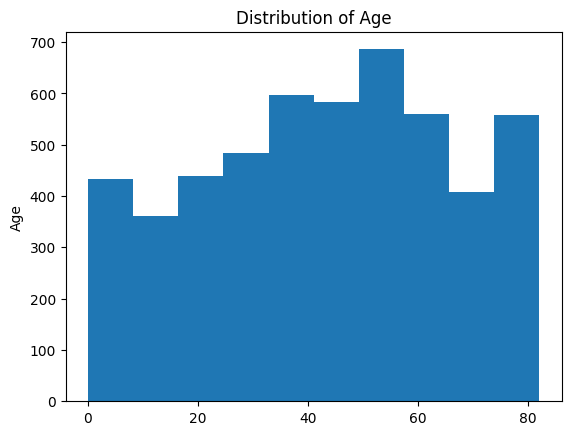

In [82]:
plt.title("Distribution of Age")
plt.ylabel("Age")
plt.hist(data["age"])

In [27]:
data[data["age"]<=1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
844,Male,1.00,0,0,No,children,Rural,89.30,21.4,Unknown,0
951,Male,1.00,0,0,No,children,Rural,123.21,15.1,Unknown,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
1093,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
1206,Female,0.72,0,0,No,children,Urban,66.36,23.0,Unknown,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,Unknown,0


### - Upon examining the dataset, the small age values (e.g., 0.08, 0.16, 0.32 years) correspond to children under 1 year old.


## Nan Values

In [84]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

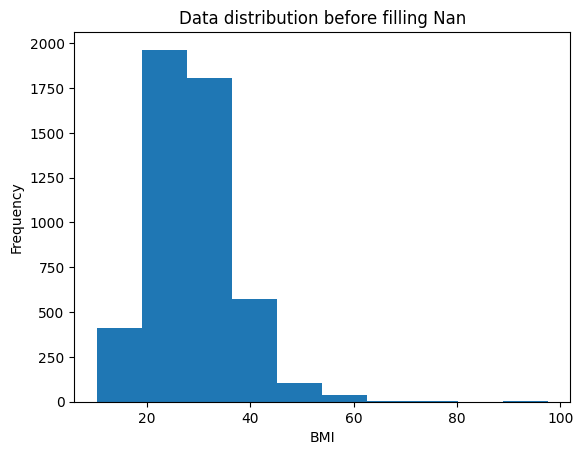

In [85]:
plt.title("Data distribution before filling Nan")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.hist(data["bmi"])
plt.show()

### Fill Nan with median since the data distribution is skewed

In [257]:
data["bmi"] = data["bmi"].fillna(data["bmi"].median())

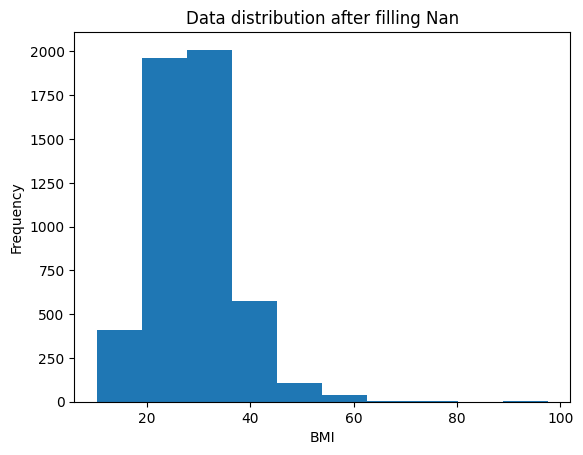

In [6]:
plt.title("Data distribution after filling Nan")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.hist(data["bmi"])
plt.show()

In [258]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Duplicated Values

In [261]:
print("Total number of duplicated rows: ", data.duplicated().sum())

Total number of duplicated rows:  0


## Detecting Outliers

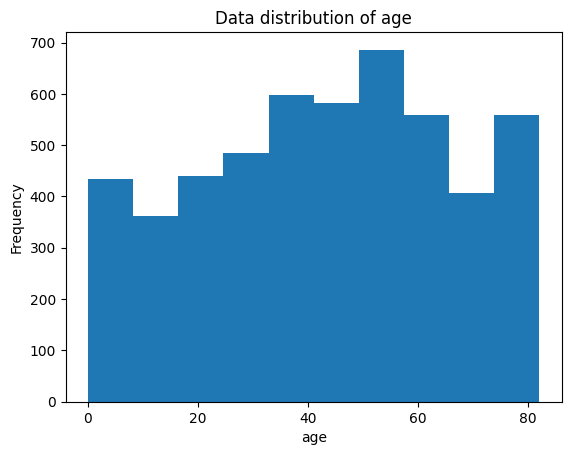

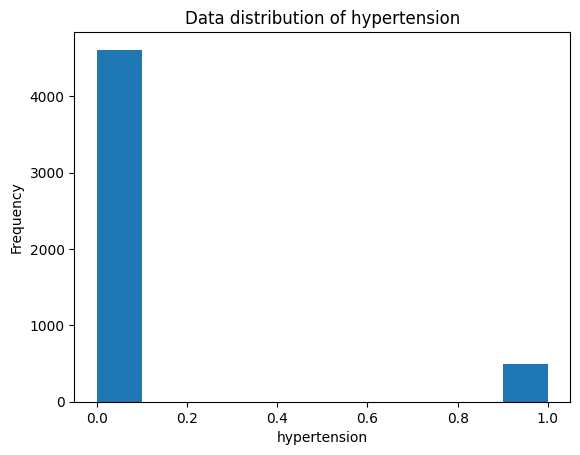

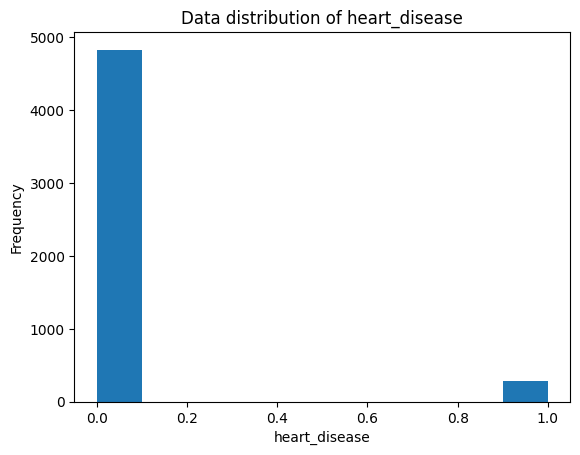

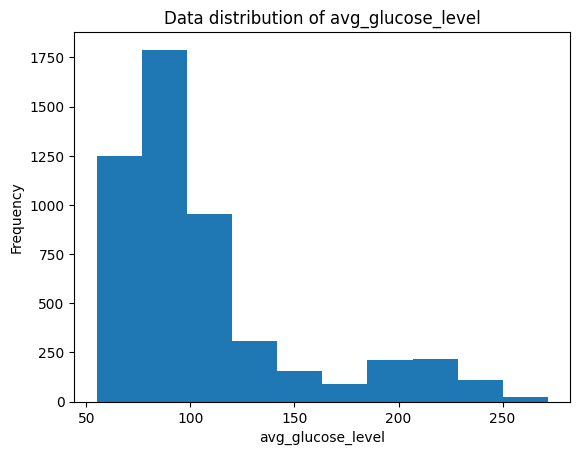

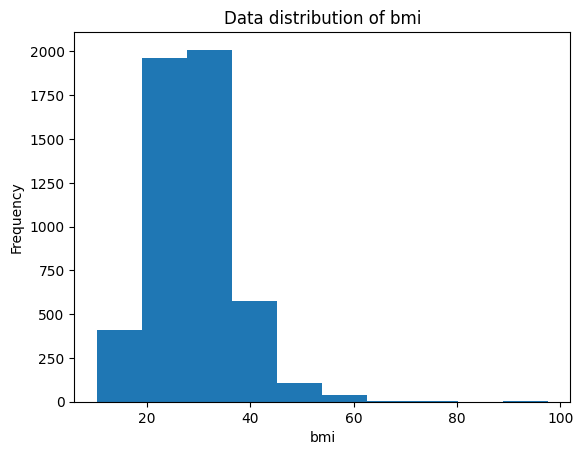

In [262]:
for col in data.drop(columns=["stroke"]).select_dtypes("number").columns:
    plt.figure()  
    plt.title(f"Data distribution of {col}")
    plt.hist(data[col])  
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

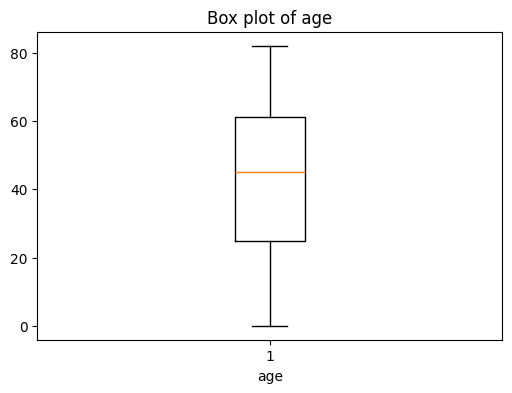

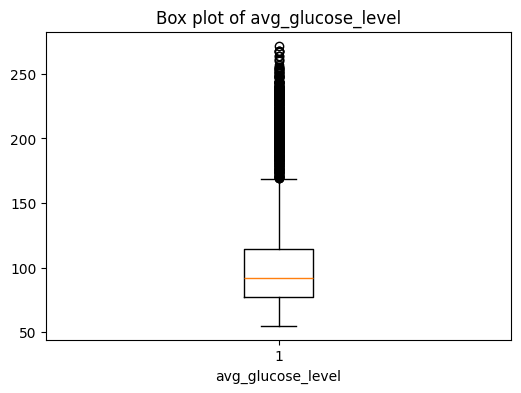

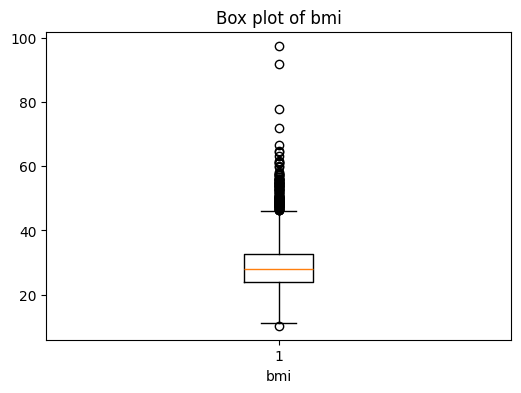

In [263]:
numeric_cols = data.drop(columns=["hypertension", "heart_disease", "stroke"]).select_dtypes(include="number").columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))  
    plt.title(f"Box plot of {col}")
    plt.boxplot(data[col])
    plt.xlabel(col)
    plt.show()


### Although there are some outliers in bmi and avg_glucose_level, I will primarily use tree-based models (e.g., Random Forest, XGBoost, CatBoost), which are naturally robust to outliers. Therefore, these extreme values will be retained, as they may carry important information for predicting stroke.

### Data Cleaning Based on Counterfactual Analysis

Upon examining the dataset and generated counterfactuals, we identified **two types of clinically implausible cases**:

1. **Extremely low glucose levels** – Some counterfactuals suggested that lowering glucose would increase stroke risk. This is **not supported by medical evidence** and occurs only in a small subset of patients (rare outliers).  

2. **Extremely high BMI values (≥ 50)** – A few instances indicated that very high BMI decreases stroke risk, which is **clinically unrealistic** and also represents a small portion of the dataset.  

Given that these cases are rare and potentially misleading, it is reasonable to remove them to **improve the plausibility and reliability** of subsequent analyses.


In [264]:
# Remove rows where avg_glucose_level <= 70 AND stroke == 1
data = data[~((data['avg_glucose_level'] <= 70) & (data['stroke'] == 1))]
data = data[~(data['bmi'] >= 50)]

## Imbalanced target classes

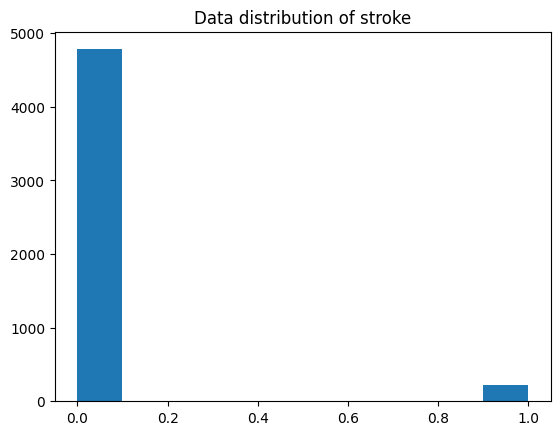

In [265]:
plt.title("Data distribution of stroke")
plt.hist(data["stroke"])
plt.show()

### - So the target value is highly imbalanced. I will using SMOTE to oversampling the minority class.

## EDA

In [267]:
data.select_dtypes("number").corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.278523,0.264197,0.243049,0.364870,0.235834
hypertension,0.278523,1.000000,0.112829,0.175750,0.148233,0.123377
heart_disease,0.264197,0.112829,1.000000,0.170209,0.055346,0.133358
avg_glucose_level,0.243049,0.175750,0.170209,1.000000,0.174595,0.164977
bmi,0.364870,0.148233,0.055346,0.174595,1.000000,0.048217
stroke,0.235834,0.123377,0.133358,0.164977,0.048217,1.000000


## Building model 

### Preprocessing

In [268]:
category_mappings = {}
dataForModel = data.copy()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    dataForModel[col] = dataForModel[col].astype('category')
    category_mappings[col] = dict(enumerate(dataForModel[col].cat.categories))
    dataForModel[col] = dataForModel[col].cat.codes

X = dataForModel.drop(columns="stroke")
y = dataForModel["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [269]:
category_mappings

{'gender': {0: 'Female', 1: 'Male', 2: 'Other'},
 'ever_married': {0: 'No', 1: 'Yes'},
 'work_type': {0: 'Govt_job',
  1: 'Never_worked',
  2: 'Private',
  3: 'Self-employed',
  4: 'children'},
 'Residence_type': {0: 'Rural', 1: 'Urban'},
 'smoking_status': {0: 'Unknown',
  1: 'formerly smoked',
  2: 'never smoked',
  3: 'smokes'}}

### SMOTE

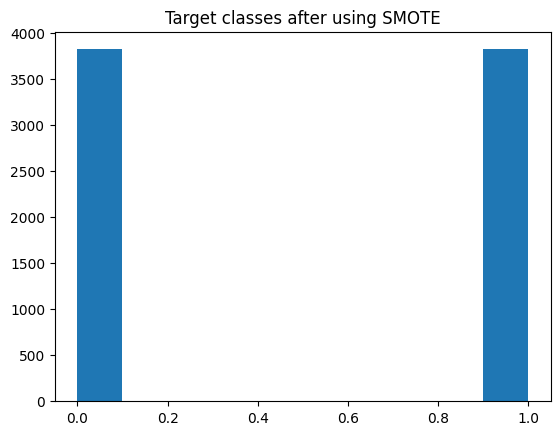

In [270]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

plt.hist(y_train_res)
plt.title("Target classes after using SMOTE")
plt.show()

### Function to calculate metrics

In [9]:

def evaluate_model(y_true, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6,5))
    sn.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=["Predicted No Stroke", "Predicted Stroke"],
        yticklabels=["Actual No Stroke", "Actual Stroke"]
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

### Random forest 

#### Tunning hyperparameters

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best recall score: 0.9953720889453539
===== Random Forest (Grid Search) =====
Accuracy: 0.550880626223092
Precision: 0.08853118712273642
Recall: 0.88
F1-Score: 0.16087751371115175
ROC-AUC: 0.7733333333333332

Confusion Matrix:
[[519 453]
 [  6  44]]


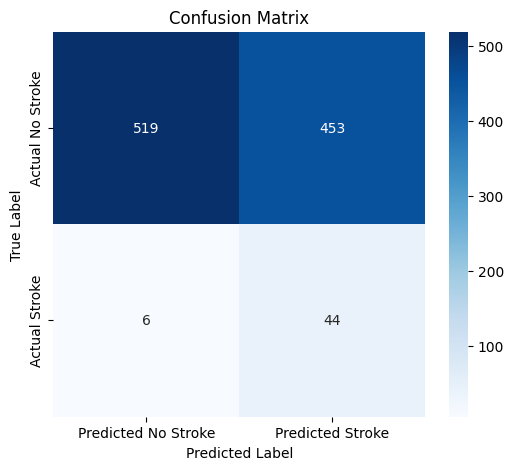


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69       972
           1       0.09      0.88      0.16        50

    accuracy                           0.55      1022
   macro avg       0.54      0.71      0.43      1022
weighted avg       0.94      0.55      0.67      1022



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 500],      # number of trees
    'max_depth': [None, 5, 10, 20],      # max depth of tree
    'min_samples_split': [2, 5, 10],     # min samples to split
    'min_samples_leaf': [1, 2, 4],       # min samples per leaf
    'class_weight': ['balanced', {0:1,1:5}, {0:1,1:10}]  # emphasize minority
}


rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',  # maximize recall for minority class
    cv=5,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train_res, y_train_res)

print("Best parameters found:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

print("===== Random Forest (Grid Search) =====")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


#### Using tunned hyperparameters

===== Random Forest =====
Accuracy: 0.6713286713286714
Precision: 0.11382113821138211
Recall: 0.9545454545454546
F1-Score: 0.2033898305084746
ROC-AUC: 0.8591954022988506

Confusion Matrix:
[[630 327]
 [  2  42]]


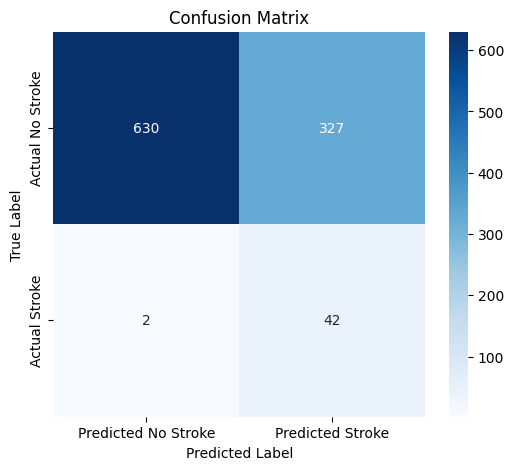


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       957
           1       0.11      0.95      0.20        44

    accuracy                           0.67      1001
   macro avg       0.56      0.81      0.50      1001
weighted avg       0.96      0.67      0.77      1001



In [271]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 2},  
    random_state=42
)


rf.fit(X_train_res, y_train_res)


y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


print("===== Random Forest =====")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


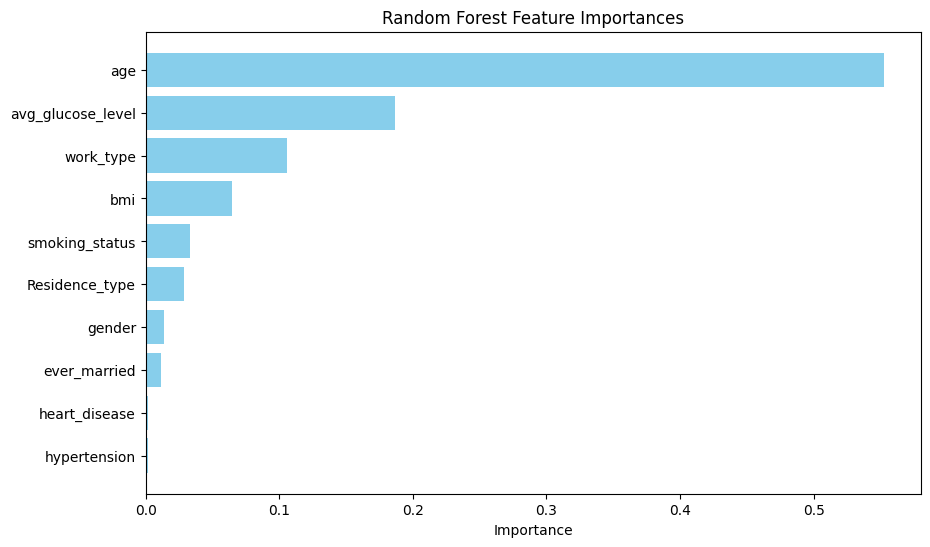

In [272]:
feature_importances = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=True)  # ascending for horizontal bar

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()


### XGboost 

d:\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:57:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== XGBoost =====
Accuracy: 0.5924075924075924
Precision: 0.09375
Recall: 0.9545454545454546
F1-Score: 0.17073170731707318
ROC-AUC: 0.851619644723093

Confusion Matrix:
[[551 406]
 [  2  42]]


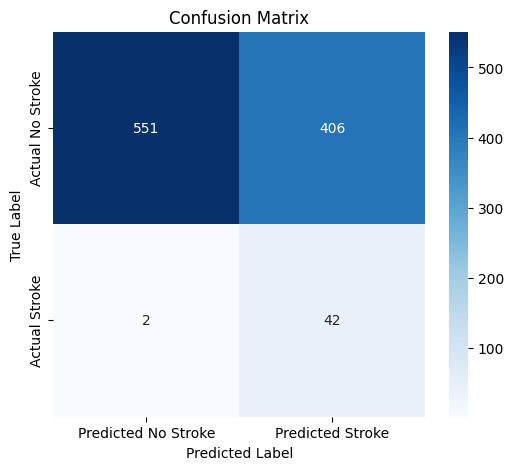


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.73       957
           1       0.09      0.95      0.17        44

    accuracy                           0.59      1001
   macro avg       0.55      0.77      0.45      1001
weighted avg       0.96      0.59      0.71      1001



In [273]:
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()  # original ratio
scale_pos_weight_tuned = scale_pos_weight * 1.5  # increase weight for minority
xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000,
    scale_pos_weight=scale_pos_weight_tuned,  # incresing weight for minority class
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("===== XGBoost =====")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)

### Catboost

0:	learn: 1.0000000	total: 30.1ms	remaining: 15s
100:	learn: 1.0000000	total: 3.34s	remaining: 13.2s
200:	learn: 1.0000000	total: 6.67s	remaining: 9.93s
300:	learn: 1.0000000	total: 10s	remaining: 6.63s
400:	learn: 1.0000000	total: 13.5s	remaining: 3.33s
499:	learn: 1.0000000	total: 16.8s	remaining: 0us
----Catboost-------
Accuracy: 0.6703296703296703
Precision: 0.11141304347826086
Recall: 0.9318181818181818
F1-Score: 0.19902912621359223
ROC-AUC: 0.8591954022988506

Confusion Matrix:
[[630 327]
 [  3  41]]


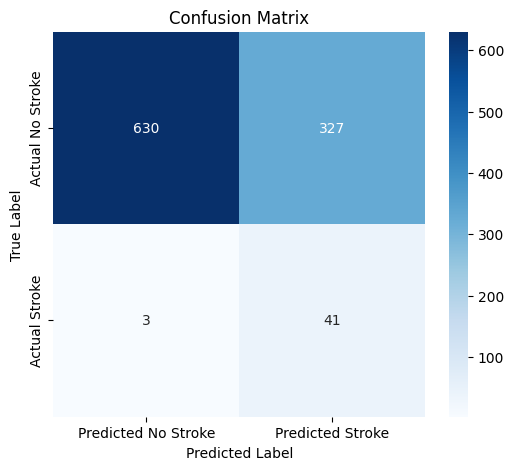


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       957
           1       0.11      0.93      0.20        44

    accuracy                           0.67      1001
   macro avg       0.55      0.80      0.50      1001
weighted avg       0.96      0.67      0.77      1001



In [274]:
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()  # original ratio
scale_pos_weight_tuned = scale_pos_weight * 1.5  # increase weight for minority
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Prepare Pool object for CatBoost (categorical features are indexed)
cat_features_indices = [X_train_res.columns.get_loc(c) for c in categorical_cols]

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='Recall',
    scale_pos_weight=scale_pos_weight_tuned,# incresing weight for minority class
    random_state=42,
    verbose=100
)

catboost_model.fit(
    X_train_res, y_train_res,
    cat_features=cat_features_indices
)

y_pred = catboost_model.predict(X_test)
y_proba = catboost_model.predict_proba(X_test)[:,1]


print("----Catboost-------")
evaluate_model(y_test, y_pred, y_proba)


### We observed that after removing those outliers(avg_glucose_level <=70 but stroke = 1) , we can see that our recall increase significantly 

### In conclusion, for healthcare applications, recall is prioritized over precision because false negatives are far more dangerous than false positives. Accepting lower precision is justified in order to ensure that critical cases are not missed.

## Explainable Insights

In [237]:
categorical_maps = {
    'gender': {0: 'Female', 1: 'Male', 2: 'Other'},
    'ever_married': {0: 'No', 1: 'Yes'},
    'work_type': {0: 'Govt_job', 1: 'Never_worked', 2: 'Private', 3: 'Self-employed', 4: 'children'},
    'Residence_type': {0: 'Rural', 1: 'Urban'},
    'smoking_status': {0: 'Unknown', 1: 'formerly smoked', 2: 'never smoked', 3: 'smokes'}
}

In [ ]:
## Map the catetory to human-readable
def transformCategory(df):
    df_copy = df.copy()  # avoid modifying original
    for col, mapping in categorical_maps.items():
        if col in df_copy.columns:  
            df_copy[col] = df_copy[col].map(mapping)
    return df_copy

In [ ]:
import dice_ml

d = dice_ml.Data(dataframe=X_train_res.assign(target=y_train_res),
                  continuous_features=['age', 'avg_glucose_level', "bmi"],  
                  outcome_name='target')  

m = dice_ml.Model(model=rf, backend='sklearn')  
exp = dice_ml.Dice(d, m, method='random')  

# 4. Generate counterfactuals
query_instance = X_test.iloc[4:5]  # can change this 
cf = exp.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")
cf_df = cf.cf_examples_list[0].final_cfs_df  

transformCategory(cf_df)


In [ ]:
predicted_target = rf.predict(query_instance)  
query_instance.loc[:, "target"] = predicted_target
transformCategory(query_instance)

In [ ]:
transformCategory(cf_df)

## Counterfactual Analysis

## 1/

We analyzed counterfactuals for a patient profile:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Female | 43  | No           | No            | Yes     | Private   | Urban     | 86.67       | 33.3 | never smoked   | 0      |

The model-generated counterfactuals for this patient are:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Female | 43  | 0            | 0             | Yes     | Private   | Urban     | 110.87      | 33.3 | formerly smoked | 1      |
| Female | 43  | 0            | 0             | Yes     | Private   | Urban     | 69.48       | 33.3 | never smoked   | 1      |
| Female | 43  | 0            | 0             | Yes     | Private   | Urban     | 60.55       | 33.3 | never smoked   | 1      |

### Interpretation

1. **Target change:** All counterfactuals flip the predicted stroke from 0 → 1.  
2. **Feature changes:** Only the **average glucose level** and **smoking status** vary significantly.  
3. **Unrealistic pattern:**  
   - Two counterfactuals suggest that **lowering average glucose level (69.48, 60.55)** increases stroke risk.  
   - This is **not clinically plausible**, as lower glucose does not increase stroke probability.  

### Actionable insight

- This highlights that the model may have learned **spurious relationships** from rare cases.  
- To generate **meaningful and medically realistic counterfactuals**, extreme or low-probability feature values should be filtered out during analysis.



In [218]:
print(data['stroke'][(data["avg_glucose_level"]<=70) & (data['stroke'] == 1)].count() / data['stroke'][(data["avg_glucose_level"]<=70) & (data['stroke'] == 0)].count() * 100)

3.7037037037037033


#### Go deeper we can see that the case that the patient has **avg_glucose_level <= 70** and has stroke is only **3,7%**. So for more reasonable analysis, we should consider those as outliers

## 2/

We examined counterfactuals for the following patient profile:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Male   | 17  | No           | No            | No      | Govt_job  | Urban     | 68.91       | 23.0 | Unknown        | 0      |

After removing extreme or unrealistic outliers (e.g., extremely low or high glucose levels), the model-generated counterfactuals are:

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|------|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Male   | 76.6 | 0            | 0             | No      | Govt_job  | Urban     | 222.16      | 23.0 | Unknown        | 1      |
| Male   | 57.1 | 0            | 0             | No      | Govt_job  | Urban     | 179.49      | 23.0 | Unknown        | 1      |
| Male   | 65.8 | 0            | 0             | No      | Govt_job  | Urban     | 227.21      | 23.0 | Unknown        | 1      |

### Interpretation

1. **Target change:** All counterfactuals flip the predicted stroke from 0 → 1.  
2. **Feature changes:** The primary changes are in **age** and **average glucose level**, which increase in the CFs.  
3. **Reasonable pattern:**  
   - Older age and higher glucose levels are associated with increased stroke risk.  
   - This aligns with clinical expectations and literature.  

### Actionable insight

- By removing outliers from the dataset, the counterfactuals now reflect **plausible and medically meaningful scenarios**.  
- This demonstrates that careful preprocessing (outlier removal) is essential for **trustworthy counterfactual explanations** in healthcare models.


## 3/

Original patient profile:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Female | 5   | No           | No            | No      | children  | Rural     | 102.04      | 18.5 | Unknown        | 0      |

Counterfactuals generated:

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type   | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|------|--------------|---------------|---------|------------|-----------|-------------|------|----------------|--------|
| Female | 49.9 | 0            | 0             | No      | Private    | Rural     | 102.04      | 18.5 | Unknown        | 1      |
| Female | 74.4 | 0            | 0             | No      | Never_worked | Rural   | 102.04      | 18.5 | Unknown        | 1      |
| Female | 76.3 | 0            | 0             | No      | Govt_job   | Rural     | 102.04      | 18.5 | Unknown        | 1      |

### Interpretation

1. **Target change:** All counterfactuals flip stroke prediction from 0 → 1.  
2. **Feature changes:** The main changes are **age** and **work type**, while glucose and BMI remain constant.  
3. **Insight:**  
   - Even at low BMI and normal glucose levels, older age and occupational stress factors (work type) increase predicted stroke risk.  
   - This suggests that **stress-related factors might be important contributors** to stroke risk in the model.  

### Actionable insight

- Counterfactual analysis highlights that **non-traditional risk factors** such as age-related stress and occupational exposure can strongly influence predicted stroke risk.  
- Proper handling of stress and lifestyle factors is crucial, especially for individuals in high-risk age groups.


## 4/

**Original patient profile:**  

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|------|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Male   | 61.0 | 1            | 1             | Yes     | Govt_job  | Rural     | 86.06       | 34.8 | never smoked   | 1      |

**Counterfactuals generated:**  

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI   | Smoking Status | Target |
|--------|------|--------------|---------------|---------|-----------|-----------|-------------|-------|----------------|--------|
| Male   | 61.0 | 1            | 1             | Yes     | children  | Rural     | 86.06       | 96.1  | never smoked   | 0      |
| Male   | 32.9 | 1            | 1             | Yes     | Govt_job  | Rural     | 86.06       | 34.8  | never smoked   | 0      |
| Male   | 61.0 | 1            | 1             | Yes     | Govt_job  | Rural     | 67.00       | 34.8  | never smoked   | 0      |

### Interpretation

1. **Target change:** All counterfactuals flip stroke prediction from 1 → 0.  
2. **Feature changes and plausibility:**  
   - The most notable change is **BMI = 96.1** in one counterfactual, which is **clinically implausible**.  
3. **Insight:**  
   - The model appears **overly sensitive to extreme BMI increases**, which can artificially reduce predicted stroke risk.  
   
### Actionable insight

- Counterfactual analysis reveals that **extreme BMI changes dominate the model’s predictions**, but these are **not realistic**.  
- For meaningful interpretation, **filtering out implausible counterfactuals** is necessary.  



In [252]:
data[(data['bmi']>=50) & (data['stroke']==1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
113,Female,45.0,0,0,Yes,Private,Rural,224.1,56.6,never smoked,1


In [251]:
data[(data['bmi']>=50) & (data['stroke']==0)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
254,Female,47.0,0,0,Yes,Private,Urban,210.95,50.1,Unknown,0
258,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0
270,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
333,Female,52.0,0,0,Yes,Private,Urban,82.24,54.7,formerly smoked,0
358,Male,52.0,0,0,Yes,Self-employed,Urban,78.40,64.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
4650,Male,54.0,0,0,Yes,Private,Rural,100.47,50.2,formerly smoked,0
4779,Female,58.0,0,0,Yes,Self-employed,Urban,66.71,51.7,never smoked,0
4838,Female,51.0,0,0,Yes,Private,Urban,107.72,60.9,Unknown,0
4906,Female,53.0,0,0,Yes,Private,Urban,70.51,54.1,never smoked,0


#### Upon examining the dataset and generated counterfactuals, we observed several instances with **extremely high BMI values (≥ 50)** that produce unrealistic or implausible predictions. Due to the dataset's high class imbalance, although higher BMI should generally increase stroke risk, the majority of these high-BMI instances have **stroke = 0**, which skews the model’s behavior. These instances can be considered **outliers**, and since they represent a small portion of the data, it is reasonable to remove them to improve the plausibility and reliability of subsequent analyses.
